In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch.optim as optim

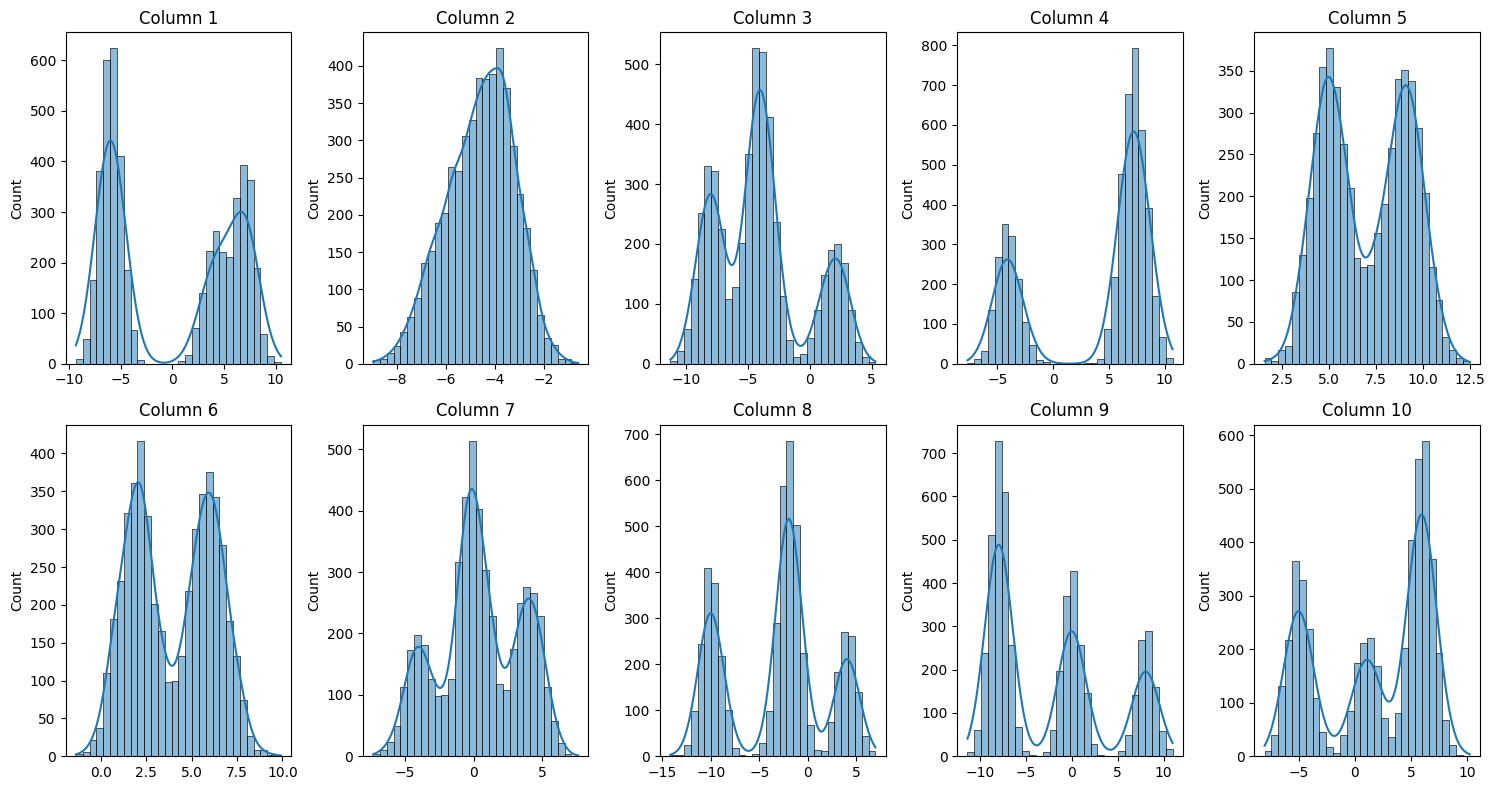

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data_size = 5000
np.random.seed(64)

# Parameters for the mixture of Gaussians
n_components = 3
weights = [0.5, 0.3, 0.2]
means = [np.random.randint(-10, 10, size=(10,)) for _ in range(n_components)]
covariances = [np.eye(10) for _ in range(n_components)]

# Generate data from the mixture of Gaussians
b = np.vstack([
    np.random.multivariate_normal(mean=means[i], cov=covariances[i], size=int(weights[i] * data_size))
    for i in range(n_components)
])

# Shuffle the data
np.random.shuffle(b)

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Flatten the 2x5 axes array for easy iteration
axes = axes.flatten()

# Loop through each column of 'b' and plot its histogram on the corresponding subplot
for i in range(10):
    sns.histplot(b[:, i], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Column {i+1}')  # Set the title for each subplot

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

X_train_5 = np.array(b[:3000, :], dtype=np.float32)
X_val_5 = np.array(b[3000:4000, :], dtype=np.float32)
X_test_5 = np.array(b[4000:5000, :], dtype=np.float32)
sc = StandardScaler()
sca_X_train_5 = sc.fit_transform(X_train_5)
sca_X_val_5 = sc.transform(X_val_5)
sca_X_test_5 = sc.transform(X_test_5)
batch_size = 64
sca_traindata_loader_5 = DataLoader(sca_X_train_5, batch_size=batch_size, shuffle=True)
sca_valdata_loader_5 = DataLoader(sca_X_val_5, batch_size=batch_size, shuffle=True)
sca_test_loader_5 = DataLoader(sca_X_test_5, batch_size=batch_size, shuffle=True)

In [28]:
import torch
import torch.nn as nn

class con_Backbone(nn.Module):
    def __init__(self, n_steps, input_dim=1, con_dim=4, n_quantiles=10):
        super().__init__()
        
        # First part of the network
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim + con_dim, 32),
            nn.ReLU()
        )
        
        # Embedding layer for the condition time t (e.g., time step)
        self.embedding_layer = nn.Embedding(n_steps, 32)
        
        # Embedding layer for the quantile alpha
        self.quantile_embedding_layer = nn.Embedding(n_quantiles, 32)
        
        # Second part of the network
        self.linear_model2 = nn.Sequential(
            nn.Linear(32 + input_dim + 32, 32),  # Updated input dimension to include quantile embedding
            nn.ReLU(),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, input_dim),  # Final output layer
        )

    def forward(self, x, con_x, idx, quantile_idx):
        # Concatenate the input data x with the conditioning variable con_x
        x = torch.cat((x, con_x), dim=1)  # Shape: [batch_size, input_dim + con_dim]
        
        # Add embedding for the time step idx (e.g., t)
        x = torch.cat((self.linear_model1(x) + self.embedding_layer(idx), con_x), dim=1)
        print(x.shape)
        print(quantile_idx.shape)
        # Get the quantile embedding for the given quantile index
        quantile_embedding = self.quantile_embedding_layer(quantile_idx)
        print(quantile_embedding.shape)
        # Concatenate the quantile embedding to the current feature vector
        x = torch.cat((x, quantile_embedding), dim=1)  # Shape: [batch_size, 32 + con_dim + 32]
        print(x.shape)
        # Pass through the second part of the network
        x = self.linear_model2(x)
        
        return x


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads  # 每个头的维度
        
        # 可训练的投影矩阵
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # 线性投影：计算 Q, K, V
        Q = self.q_proj(query)  # [batch_size, seq_len, embed_dim]
        K = self.k_proj(key)    # [batch_size, seq_len, embed_dim]
        V = self.v_proj(value)  # [batch_size, seq_len, embed_dim]
        
        # 分头：变形为 [batch_size, num_heads, seq_len, head_dim]
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        # 计算注意力分数：scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))
        attention_weights = F.softmax(attention_scores, dim=-1)  # [batch_size, num_heads, seq_len, seq_len]
        
        # 注意力加权
        attended = torch.matmul(attention_weights, V)  # [batch_size, num_heads, seq_len, head_dim]
        
        # 拼接多头的结果
        attended = attended.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)
        
        # 输出投影
        output = self.out_proj(attended)  # [batch_size, seq_len, embed_dim]
        return output


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        
        # Multi-Head Attention
        self.self_attention = MultiHeadAttention(embed_dim, num_heads)
        
        # 前馈神经网络
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        
        # 层归一化
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):

        attn_output = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # 前馈神经网络：残差连接 + LayerNorm
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))

        return x


class TransformerEncoderLayer_decay(nn.Module):
    def __init__(self, embed_dim,output_dim,num_heads, ff_dim, dropout=0.1):
        super(TransformerEncoderLayer_decay, self).__init__()
        
        # Multi-Head Attention
        self.self_attention = MultiHeadAttention(embed_dim, num_heads)
        
        # 前馈神经网络
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, output_dim)
        )
        
        # 层归一化
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(output_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):

        attn_output = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # 前馈神经网络：残差连接 + LayerNorm
        ffn_output = self.ffn(x)
        x = self.norm2(self.dropout(ffn_output))

        return x
    


class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, dropout=0.1,ifdecay=False):
        super(TransformerEncoder, self).__init__()
        self.embedddecay_list = [embed_dim - i * (embed_dim // num_layers) for i in range(num_layers)]


        self.embedd_decay = nn.ModuleList([
            TransformerEncoderLayer_decay(self.embedddecay_list[i],self.embedddecay_list[i+1], num_heads, ff_dim, dropout)
            for i in range(num_layers-1)])
        
        self.ifdecay = ifdecay
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        
    def forward(self, x, mask=None):
        if self.ifdecay:
            for layers in self.embedd_decay:
                x = layers(x,mask)
        else:
            for layer in self.layers:
                x = layer(x, mask)
        return x


In [19]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        
        # 多头自注意力
        self.self_attention = MultiHeadAttention(embed_dim, num_heads)
        
        # Encoder-Decoder Attention
        self.encoder_decoder_attention = MultiHeadAttention(embed_dim, num_heads)
        
        # 前馈神经网络
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        
        # 层归一化
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, enc_output, self_mask=None, enc_mask=None):
        enc_output = enc_output.squeeze(1)
        attn_output = torch.concat([x, enc_output], dim=1)
        attn_output = nn.Linear(attn_output.shape[1],1)(attn_output)  
        
        return attn_output

In [85]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        
        # 多头自注意力
        self.self_attention = MultiHeadAttention(embed_dim, num_heads)
        
        # Encoder-Decoder Attention
        self.encoder_decoder_attention = MultiHeadAttention(embed_dim, num_heads)
        
        # 前馈神经网络
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        
        # 层归一化
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, enc_output, self_mask=None, enc_mask=None):
        # Self-Attention
        _x = x
        print(x.shape)
        x = self.self_attention(query=x, key=x, value=x, mask=self_mask)
        
        x = self.dropout(x)
        print(x.shape)
        x = self.norm1(x + _x)
        print(x.shape)
        # Encoder-Decoder Attention
        _x = x
        enc_output = enc_output.permute(0, 2, 1)
    
        print(x.shape)
        x = self.encoder_decoder_attention(query=x, key=enc_output, value=enc_output, mask=enc_mask)
        x = self.dropout(x)
        x = self.norm2(x + _x)

        # Feed-Forward Network
        _x = x
        x = self.ffn(x)
        x = self.dropout(x)
        x = self.norm3(x + _x)
        x = x.squeeze(-1)
        x = nn.Linear(x.shape[1],1)(x)
        return x


In [86]:
class TransformerDecoder(nn.Module):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        
        # 创建多个 Transformer Decoder 层
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        
    def forward(self, x, enc_output, self_mask=None, enc_mask=None):
        for layer in self.layers:
            x = layer(x, enc_output, self_mask, enc_mask)
        return x


In [87]:
class TransformerBlock(nn.Module):
    def __init__(self, num_layers, embed_dim,decoder_embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        
        # Encoder 和 Decoder
        self.encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim, dropout)
        self.decoder = TransformerDecoder(num_layers, decoder_embed_dim, num_heads, ff_dim, dropout)
        self.embedding_layer = nn.Embedding(101, embed_dim)
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
        enc_output = self.encoder(src, src_mask)
        
        # 解码器部分
        dec_output = self.decoder(tgt, enc_output, tgt_mask, memory_mask)
        
        return dec_output


In [89]:
from torch.utils.data import DataLoader
transformer = TransformerBlock(num_layers=3, embed_dim=b.shape[1]-1,decoder_embed_dim=1, num_heads=1, ff_dim=128)
for i in sca_traindata_loader_5:
    i = i.unsqueeze(1)   
    print(transformer(i[:,:,:-1], i[:,:,-1].reshape(-1,1)).shape)

torch.Size([64, 1])
torch.Size([64, 1, 1])
torch.Size([64, 64, 1])
torch.Size([64, 64, 1])
torch.Size([64, 1])
torch.Size([64, 1, 1])
torch.Size([64, 64, 1])
torch.Size([64, 64, 1])
torch.Size([64, 1])
torch.Size([64, 1, 1])
torch.Size([64, 64, 1])
torch.Size([64, 64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1, 1])
torch.Size([64, 64, 1])
torch.Size([64, 64, 1])
torch.Size([64, 1])
torch.Size([64, 1, 1])
torch.Size([64, 64, 1])
torch.Size([64, 64, 1])
torch.Size([64, 1])
torch.Size([64, 1, 1])
torch.Size([64, 64, 1])
torch.Size([64, 64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1, 1])
torch.Size([64, 64, 1])
torch.Size([64, 64, 1])
torch.Size([64, 1])
torch.Size([64, 1, 1])
torch.Size([64, 64, 1])
torch.Size([64, 64, 1])
torch.Size([64, 1])
torch.Size([64, 1, 1])
torch.Size([64, 64, 1])
torch.Size([64, 64, 1])
torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64, 1, 1])
torch.Size([64, 64, 1])
torch.Size([64, 64, 1])
torch.Size([64, 1])
torch.Size

In [32]:
import torch

# 假设输入张量
x = torch.randn(64, 64, 1)

# 去掉第二个维度，保留第一和第三维度
output = x.squeeze(-1)  # 或者 x.squeeze(2)
print(output.shape)  # 输出 [64, 64]


torch.Size([64, 64, 1, 1])


In [59]:
import torch

# 假设 input_tensor 是形状为 [64, 0, 10] 的张量
input_tensor = torch.randn(64, 1, 10)  # 示例张量

# 使用 unsqueeze 增加一个维度，将 0 维度替换成 1
output_tensor = input_tensor.squeeze(1)

print(output_tensor.shape)  # 输出: torch.Size([64, 1, 10

torch.Size([64, 10])


In [ ]:
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T, input_dim):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''
        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = TransformerBlock(num_layers=2, embed_dim=input_dim, num_heads=  int(input_dim/2), ff_dim=128)
        
        self.to(device = self.device)

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        output, epsilon, alpha_bar = self.forward(x, idx=idx, get_target=True)
        loss = (output - epsilon).square().mean()
        return loss

        
    def forward(self, x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (epsilon prediction)

        '''

        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * x + torch.sqrt(1 - used_alpha_bars) * epsilon
            
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = x
            
        x_tilde = x_tilde.unsqueeze(1)
            
        output = self.backbone(x_tilde,x_tilde).reshape(-1, x.size(1))
        return (output, epsilon, used_alpha_bars) if get_target else output
        

In [ ]:
class DiffusionProcess():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, datadim):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        datadim         : data dimension
        '''

        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])
        self.datadim = datadim
        
        self.diffusion_fn = diffusion_fn
        self.device = device

    
    def _one_diffusion_step(self, x):
        '''
        x   : perturbated data
        '''
        for idx in reversed(range(len(self.alpha_bars))):
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            sqrt_tilde_beta = torch.sqrt((1 - self.alpha_prev_bars[idx]) / (1 - self.alpha_bars[idx]) * self.betas[idx])
            predict_epsilon = self.diffusion_fn(x, idx)
            print(predict_epsilon.shape)
            mu_theta_xt = torch.sqrt(1 / self.alphas[idx]) * (x - self.betas[idx] / torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon)
            x = mu_theta_xt + sqrt_tilde_beta * noise
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step 
        '''
        sample = torch.randn([sampling_number,self.datadim]).to(device = self.device).squeeze()
        sampling_list = []
        
        final = None
        for idx, sample in enumerate(self._one_diffusion_step(sample)):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

In [ ]:
batch_size =64
beta_1 = 1e-4
beta_T = 0.02
T = 50

In [ ]:
def traincon_ddpm(model,optimizer,num_epochs,traindata_loader,valdata_loader,early_stopping):
    best_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(num_epochs):
        whole_loss = 0
        for i, batch in enumerate(traindata_loader):
            batch_size = batch.shape[0]
            batch = batch.cuda()
            loss = model.loss_fn(batch)
            whole_loss+=loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        val_loss = 0
        with torch.no_grad():
            for val_batch in valdata_loader:
                batch = val_batch.cuda()
                val_loss+=model.loss_fn(batch)
            val_loss /= len(valdata_loader)
        if (epoch) % 20 == 0:
            print('epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, whole_loss/len(traindata_loader), val_loss.item()))
        loss_new = val_loss
        if loss_new < best_loss:
            best_loss = loss_new
            early_stopping_counter = 0
            print('epoch: {}, find new best loss: Train Loss: {:.4f}'.format(epoch,best_loss))
            print('-' * 10)
        else:
            early_stopping_counter += 1
        if early_stopping_counter == early_stopping:
            print("Early stopping after {} epochs".format(epoch))
            break
    

In [ ]:
from torchviz import make_dot

# 假设你有一个输入数据（例如，batch_size=640, sequence_length=1, embed_dim=10）
dummy_input = torch.randn(640, 1, b.shape[1])  # 输入的形状应该和实际数据一样
output = transformer(dummy_input, dummy_input)  # 运行一次前向传播

# 可视化计算图
dot = make_dot(output, params=dict(transformer.named_parameters()))
dot.render("transformer_model", format="png")  # 保存为 PNG 图片


'transformer_model.png'

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
model = Model(device, beta_1, beta_T, T, X_train_5.shape[1])
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
process = DiffusionProcess(beta_1, beta_T, T, model, device, X_train_5.shape[1])
traincon_ddpm(model,optim,500,sca_traindata_loader_5,sca_valdata_loader_5,100)

epoch: 0, Train Loss: 1.1564, Val Loss: 1.0109
epoch: 0, find new best loss: Train Loss: 1.0109
----------
epoch: 1, find new best loss: Train Loss: 0.9117
----------
epoch: 2, find new best loss: Train Loss: 0.8693
----------
epoch: 3, find new best loss: Train Loss: 0.8159
----------
epoch: 4, find new best loss: Train Loss: 0.7738
----------
epoch: 5, find new best loss: Train Loss: 0.7726
----------
epoch: 6, find new best loss: Train Loss: 0.7585
----------
epoch: 7, find new best loss: Train Loss: 0.7332
----------
epoch: 9, find new best loss: Train Loss: 0.7065
----------
epoch: 11, find new best loss: Train Loss: 0.7064
----------
epoch: 12, find new best loss: Train Loss: 0.6985
----------
epoch: 14, find new best loss: Train Loss: 0.6888
----------
epoch: 15, find new best loss: Train Loss: 0.6740
----------
epoch: 18, find new best loss: Train Loss: 0.6714
----------
epoch: 19, find new best loss: Train Loss: 0.6497
----------
epoch: 20, Train Loss: 0.6776, Val Loss: 0.6418

torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([1000

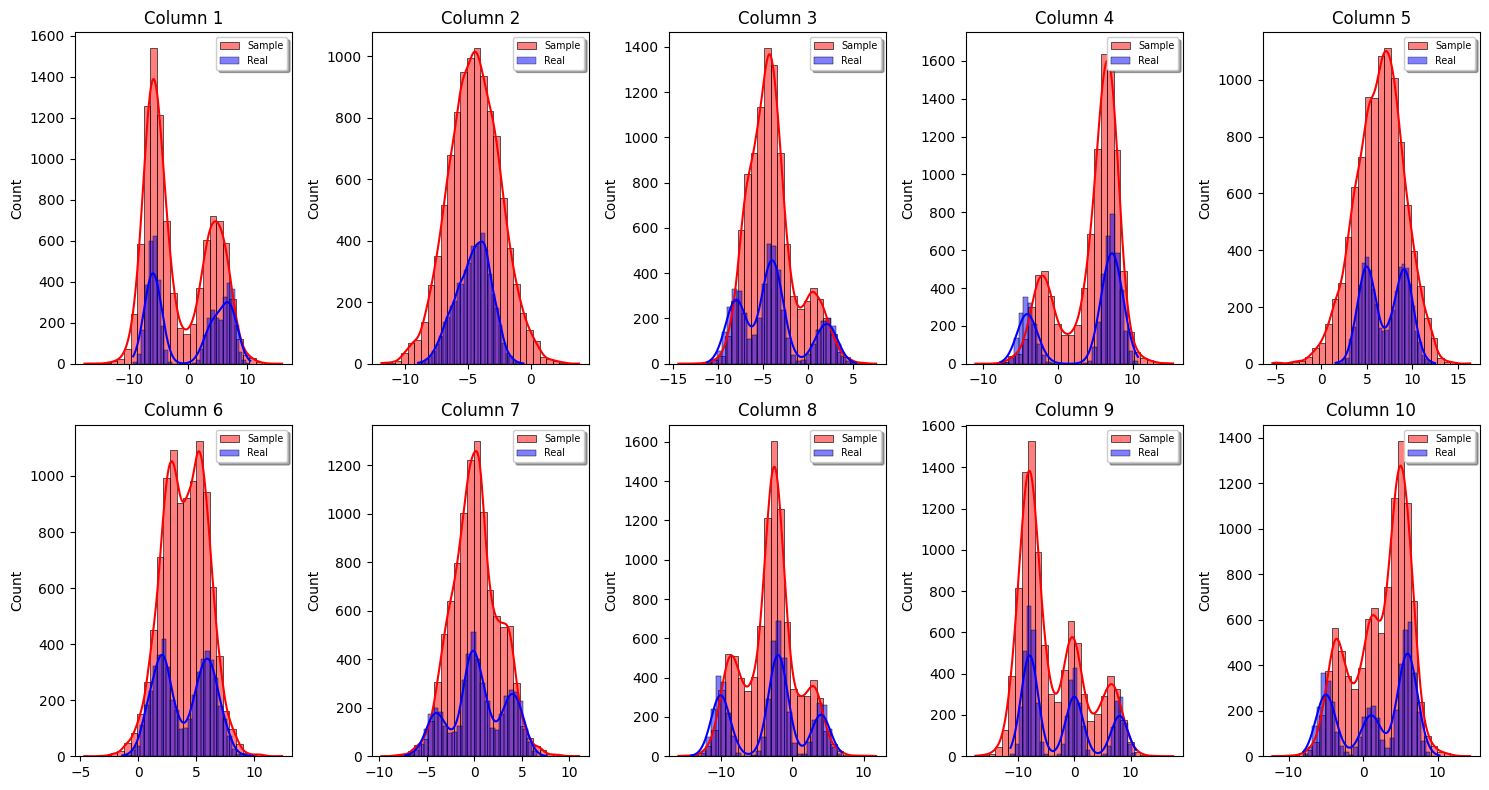

In [ ]:
sampling_number = 10000
only_final = True
sample = process.sampling(sampling_number, only_final)
sample = sample.reshape(-1, 10)
sample =sc.inverse_transform(sample.cpu().detach().numpy())
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

for i in range(10):
    sns.histplot(sample[:, i], kde=True, bins=30, ax=axes[i],color='red',label='Sample')
    sns.histplot(b[:, i], kde=True, bins=30, ax=axes[i],color='blue',label='Real')
    legend = axes[i].legend(loc='upper right', shadow=True, fontsize='x-small')
    axes[i].set_title(f'Column {i+1}') 


plt.tight_layout()

# Show the plot
plt.show()
